# EDA

## Imports

In [129]:
## Jupyter Notebook setting to reload functions when called
%load_ext autoreload
%autoreload 2

In [130]:
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import shap

import os, sys

sys.path.append(os.path.abspath('../../'))

## Personal functions
from custom_functions import classification as clf

# from sklearnex import patch_sklearn
# patch_sklearn()

In [216]:
from imblearn.combine import SMOTEENN, SMOTETomek
# from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE

from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

import xgboost as xgb

In [132]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('display.max_rows', 100)

set_config(transform_output = 'pandas')

## Data

In [133]:
## Read configured settings from JSON file

with open('../../config/Shared_Settings.json', 'r') as file:
    settings = json.load(file)
    
settings

{'source': '../../data/WA_Fn-UseC_-HR-Employee-Attrition.csv',
 'feature_types': {'feature_names_categorical': ['EducationField',
   'Gender',
   'JobRole',
   'OverTime'],
  'feature_names_continuous': ['Age',
   'DailyRate',
   'DistanceFromHome',
   'Education',
   'EnvironmentSatisfaction',
   'HourlyRate',
   'JobInvolvement',
   'JobLevel',
   'JobSatisfaction',
   'MonthlyIncome',
   'MonthlyRate',
   'NumCompaniesWorked',
   'PercentSalaryHike',
   'PerformanceRating',
   'RelationshipSatisfaction',
   'StockOptionLevel',
   'TotalWorkingYears',
   'TrainingTimesLastYear',
   'WorkLifeBalance',
   'YearsAtCompany',
   'YearsInCurrentRole',
   'YearsSinceLastPromotion',
   'YearsWithCurrManager'],
  'feature_names_ordinal': ['BusinessTravel']},
 'target_feature': ['Attrition']}

In [134]:
data = pd.read_csv(settings['source'])
data

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,3,Male,41,4,2,Laboratory Technician,4,Married,2571,12290,4,Y,No,17,3,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,4,Male,42,2,3,Healthcare Representative,1,Married,9991,21457,4,Y,No,15,3,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,2,Male,87,4,2,Manufacturing Director,2,Married,6142,5174,1,Y,Yes,20,4,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,4,Male,63,2,2,Sales Executive,2,Married,5390,13243,2,Y,No,14,3,4,80,0,17,3,2,9,6,0,8


In [135]:
data.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

# Target

In [136]:
target_feat = settings['target_feature'][0]
target_feat

'Attrition'

In [137]:
data[target_feat].value_counts(normalize=True).round(2)

Attrition
No    0.84
Yes   0.16
Name: proportion, dtype: float64

Review - `Attrition`

- Binary feature
    - Convert to boolean values
- Class imbalance favors the "No" category
    - Include balancing via SMOTE in pre-processing pipeline

In [138]:
data[target_feat] = data[target_feat].replace({'No':0, 'Yes':1})
data[target_feat]

0       1
1       0
2       1
3       0
4       0
       ..
1465    0
1466    0
1467    0
1468    0
1469    0
Name: Attrition, Length: 1470, dtype: int64

# Notes

---

**Target Composition**

> The target is a binary feature indicating whether an employee quit.
>
>
> The feature's classes are imbalanced in favor of the "No" class.
>   - This needs to be addressed as part of the modeling pipeline

---

# Categorical Features

In [139]:
(data[settings['feature_types']['feature_names_categorical']]
 .describe()
 .T
 .sort_values(by = ["unique", "freq"], ascending = False))

,count,unique,top,freq
JobRole,1470,9,Sales Executive,326
EducationField,1470,6,Life Sciences,606
OverTime,1470,2,No,1054
Gender,1470,2,Male,882


# JobRole

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


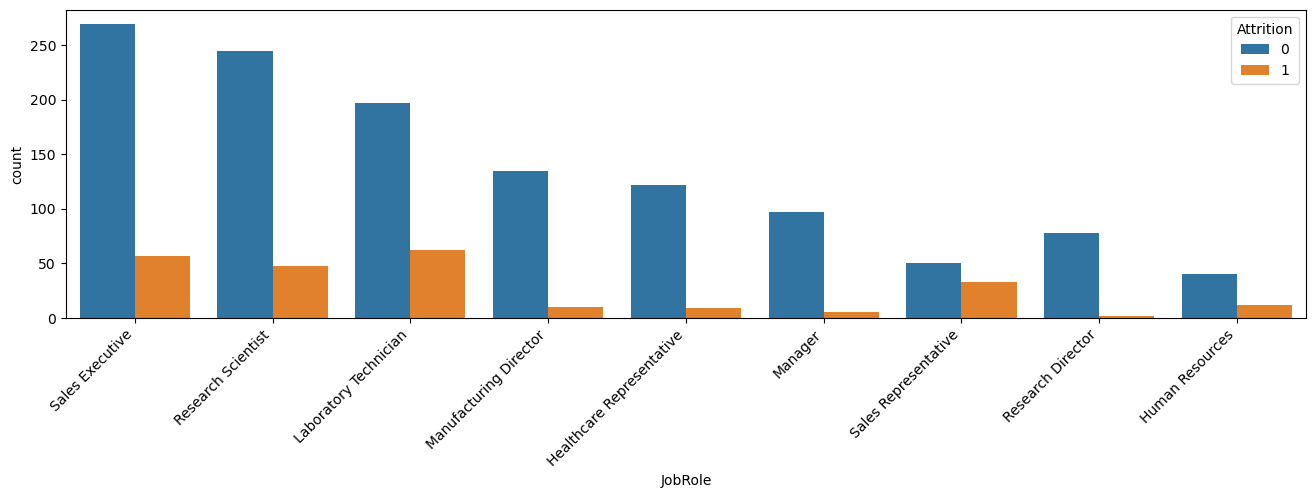

In [140]:
fig, ax = plt.subplots(figsize = (16,4))

sns.countplot(data = data, x = 'JobRole', hue = settings['target_feature'][0], ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha='right');

# EducationField

In [141]:
# px.box(data_frame=data, x = 'BusinessTravel', y = 'Attrition',
#        category_orders = {'BusinessTravel': ['Non-Travel', 'Travel_Rarely', 'Travel_Frequently']})

# OverTime

# Gender

# JobRole

# OverTime

## BusinessTravel

In [142]:
data['BusinessTravel'].unique()

array(['Travel_Rarely', 'Travel_Frequently', 'Non-Travel'], dtype=object)

In [143]:
cond = [data['BusinessTravel'] == 'Non-Travel',
        data['BusinessTravel'] == 'Travel_Rarely',
        data['BusinessTravel'] == 'Travel_Frequently']

choice = [0, 1, 2]

data['BusinessTravelXF'] = np.select(cond, choice, np.nan).astype(int)

In [144]:
data['BusinessTravelXF']

0       1
1       2
2       1
3       2
4       1
       ..
1465    2
1466    1
1467    1
1468    2
1469    1
Name: BusinessTravelXF, Length: 1470, dtype: int32

# Modeling

## Train-Test Split

In [145]:
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravelXF
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5,1
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7,2
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0,1
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0,2
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2,1


In [146]:
X = data.drop(columns = [settings['target_feature'][0], 'EmployeeNumber', 'StandardHours', 'BusinessTravel'])
y = data[settings['target_feature'][0]]

In [147]:
X.head()

,Age,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravelXF
0,41,1102,Sales,1,2,Life Sciences,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,0,8,0,1,6,4,0,5,1
1,49,279,Research & Development,8,1,Life Sciences,1,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,1,10,3,3,10,7,1,7,2
2,37,1373,Research & Development,2,2,Other,1,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,0,7,3,3,0,0,0,0,1
3,33,1392,Research & Development,3,4,Life Sciences,1,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,0,8,3,3,8,7,3,0,2
4,27,591,Research & Development,2,1,Medical,1,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,1,6,3,3,2,2,2,2,1


In [148]:
## Splitting - stratify to maintain class balance b/t X_train/_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, 
                                                    random_state=42, 
                                                    stratify=y)

# Create Preprocessing Pipeline

In [149]:
## Specifying data type columns for preprocessing
num_cols = settings['feature_types']['feature_names_continuous']

cat_cols = settings['feature_types']['feature_names_categorical']

# ord_cols = settings['feature_types']['feature_names_ordinal']

# ord_order = ['Non-Travel', 'Travel_Rarely', 'Travel_Frequently']

In [150]:
## Creating ColumnTransformer and sub-transformers for imputation and encoding

### --- Creating column pipelines --- ###

cat_pipe = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore',
                                                 sparse_output=False,
                                                 drop= 'if_binary'))])

num_pipe = Pipeline(steps=[('scaler', StandardScaler())])

# ord_pipe = Pipeline(steps=[('ordenc',
#                             OrdinalEncoder(categories=[ord_order],
#                                            handle_unknown='use_encoded_value',
#                                            unknown_value=-1,
#                                            dtype=int))])

# ### --- Instantiating the ColumnTransformer --- ###
# preprocessor = ColumnTransformer(
#                     transformers=[
#                         ('num', num_pipe, num_cols),
#                         ('cat', cat_pipe, cat_cols),
#                         ('ord', ord_pipe, ord_cols)])

### --- Instantiating the ColumnTransformer --- ###
preprocessor = ColumnTransformer(
                    transformers=[
                        ('num', num_pipe, num_cols),
                        ('cat', cat_pipe, cat_cols)])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Age', 'DailyRate', 'DistanceFromHome',
                                  'Education', 'EnvironmentSatisfaction',
                                  'HourlyRate', 'JobInvolvement', 'JobLevel',
                                  'JobSatisfaction', 'MonthlyIncome',
                                  'MonthlyRate', 'NumCompaniesWorked',
                                  'PercentSalaryHike', 'PerformanceRating',
                                  'RelationshipSatisfaction',
                                  'StockOptionLevel', 'TotalWorkingYears',
                                  'TrainingTimesLastYear', 'WorkLifeBalance',
                                  'YearsAtCompany', 'YearsInCurrentRole',
                                  'YearsSinceLastPromotion',
                                  'YearsWithCurrManager']),
                                ('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['EducationField', 'Gender', 'JobRole',
                                  'OverTime'])])

In [151]:
## Fitting feature preprocessor
preprocessor.fit(X_train)

X_train_df = preprocessor.transform(X_train)

X_test_df = preprocessor.transform(X_test)

In [152]:
# X_train_df

In [153]:
# X_test_df

# Correct Target Imbalance via SMOTE

## SMOTE

In [201]:
## Handle the target feature's class imbalance via SMOTE with Tomek Links
sm = SMOTE(sampling_strategy='auto', random_state=42)

X_sm, y_sm = sm.fit_resample(X_train_df, y_train)

# X_smv, y_smv = sm.fit_resample(X_train_df.values, y_train.values)

In [202]:
logreg = LogisticRegression(random_state=42, n_jobs=-1)

logreg.fit(X_sm, y_sm)

LogisticRegression(n_jobs=1, random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.80      0.81       924
           1       0.80      0.83      0.82       924

    accuracy                           0.81      1848
   macro avg       0.81      0.81      0.81      1848
weighted avg       0.81      0.81      0.81      1848



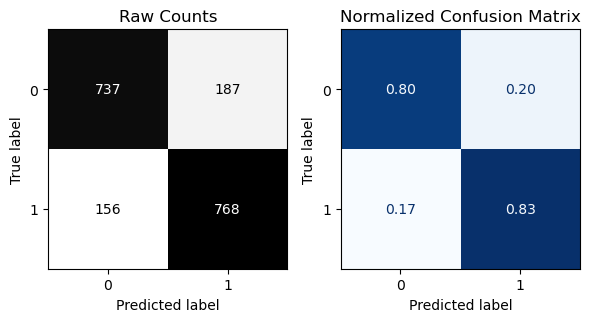


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       309
           1       0.40      0.61      0.48        59

    accuracy                           0.79       368
   macro avg       0.66      0.72      0.68       368
weighted avg       0.83      0.79      0.81       368



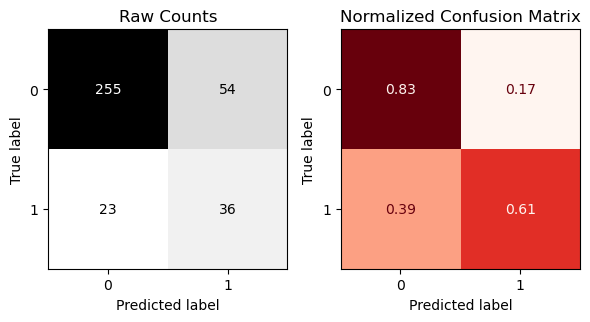

In [203]:
clf.jmi_evaluate_classification(model = logreg,
                                X_train = X_sm,
                                y_train = y_sm,
                                X_test = X_test_df,
                                y_test = y_test)

In [197]:
# y_pred_train = logreg.predict(X_sm)

# # Evaluate the classifier
# print("\nClassification Report - Training - SMOTE:\n\n", classification_report(y_sm, y_pred_train))
# ConfusionMatrixDisplay.from_predictions(y_sm, y_pred_train, cmap = 'Blues', normalize = "true");

In [200]:
# y_pred = logreg.predict(X_test_df)

# # Evaluate the classifier
# print("\nClassification Report - Test - SMOTE:\n\n", classification_report(y_test, y_pred))
# ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'Blues', normalize = "true");

In [ ]:
# X_sm

In [ ]:
# X_smv

## SMOTETomek

In [154]:
## Handle the target feature's class imbalance via SMOTE with Tomek Links
smt = SMOTETomek(sampling_strategy='auto', random_state=42)
X_smt, y_smt = smt.fit_resample(X_train_df, y_train)

In [218]:
logreg = LogisticRegression(random_state=42, n_jobs=-1)
logreg.fit(X_smt, y_smt)

LogisticRegression(n_jobs=1, random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.80      0.81       924
           1       0.80      0.83      0.82       924

    accuracy                           0.81      1848
   macro avg       0.81      0.81      0.81      1848
weighted avg       0.81      0.81      0.81      1848



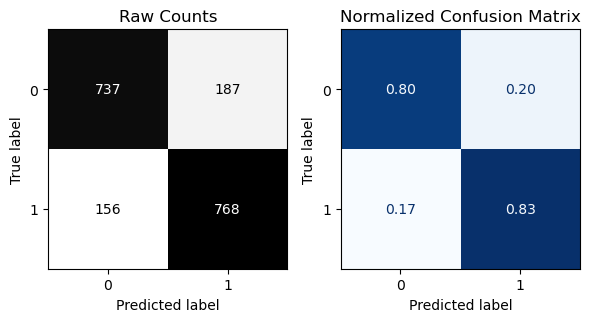


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       309
           1       0.40      0.61      0.48        59

    accuracy                           0.79       368
   macro avg       0.66      0.72      0.68       368
weighted avg       0.83      0.79      0.81       368



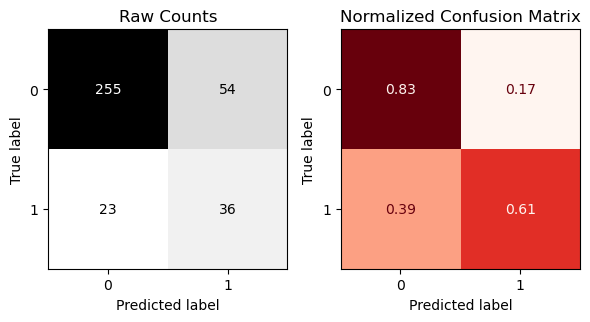

In [207]:
clf.jmi_evaluate_classification(model = logreg,
                                X_train = X_smt,
                                y_train = y_smt,
                                X_test = X_test_df,
                                y_test = y_test)

In [204]:
# y_pred_train = logreg.predict(X_smt)

# # Evaluate the classifier
# print("\nClassification Report - Training - SMOTETomek:\n\n", classification_report(y_smt, y_pred_train))
# ConfusionMatrixDisplay.from_predictions(y_smt, y_pred_train, cmap = 'Blues', normalize = "true");

In [205]:
# y_pred_test = logreg.predict(X_test_df)

# # Evaluate the classifier
# print("\nClassification Report - Test - SMOTETomek:\n\n", classification_report(y_pred_test, y_pred))
# ConfusionMatrixDisplay.from_predictions(y_pred_test, y_pred, cmap = 'Blues', normalize = "true");

In [206]:

# # Evaluate the classifier
# print("\nSMOTETomek - Classification Report:\n\n", classification_report(y_test, y_pred))
# ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'Blues', normalize = "true")

In [210]:
# logreg = LogisticRegression(random_state=42, n_jobs=-1)

# logreg.fit(X_smv, y_smv)

# y_pred = logreg.predict(X_test_df)

# # Evaluate the classifier
# print("\nSMOTETomek - Classification Report:\n\n", classification_report(y_test, y_pred))
# ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'Blues', normalize = "true")

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       924
           1       1.00      1.00      1.00       924

    accuracy                           1.00      1848
   macro avg       1.00      1.00      1.00      1848
weighted avg       1.00      1.00      1.00      1848



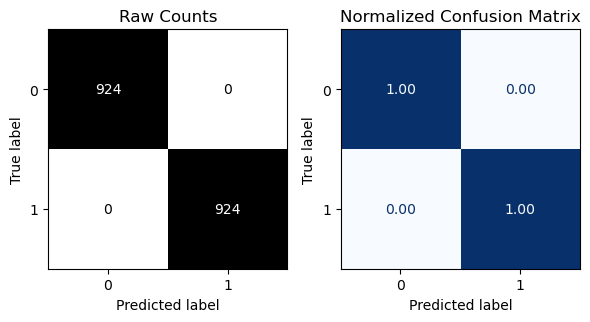


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       309
           1       0.58      0.24      0.34        59

    accuracy                           0.85       368
   macro avg       0.73      0.60      0.63       368
weighted avg       0.82      0.85      0.82       368



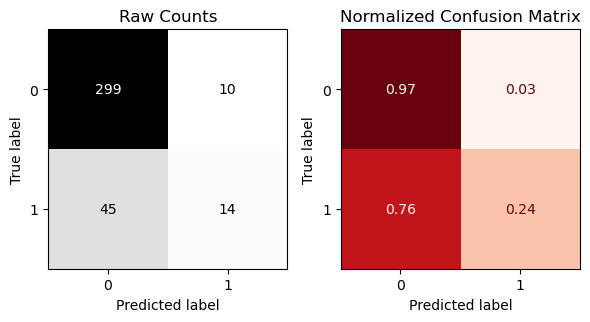

In [215]:
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

rfc.fit(X_sm, y_sm)

# y_pred = rfc.predict(X_test_df)

# # Evaluate the classifier
# print("\nSMOTETomek - Classification Report:\n\n", classification_report(y_test, y_pred))
# ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'Blues', normalize = "true")

clf.jmi_evaluate_classification(model = rfc,
                                X_train = X_smt,
                                y_train = y_smt,
                                X_test = X_test_df,
                                y_test = y_test)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       924
           1       1.00      1.00      1.00       924

    accuracy                           1.00      1848
   macro avg       1.00      1.00      1.00      1848
weighted avg       1.00      1.00      1.00      1848



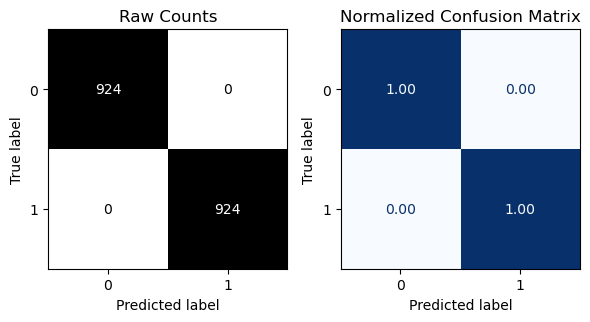


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       309
           1       0.58      0.31      0.40        59

    accuracy                           0.85       368
   macro avg       0.73      0.63      0.66       368
weighted avg       0.83      0.85      0.83       368



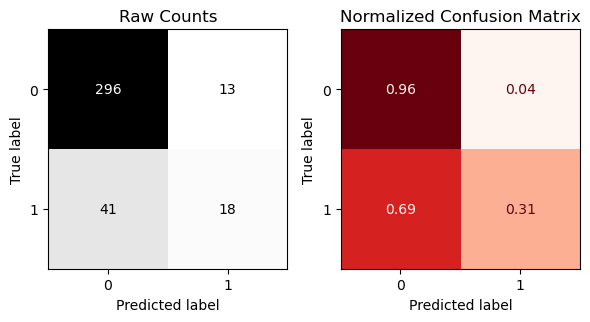

In [214]:
hgbc = HistGradientBoostingClassifier(random_state=42)

hgbc.fit(X_sm, y_sm)

# y_train_pred = hgbc.predict(y_sm)

y_test_pred = hgbc.predict(X_test_df)

# # Evaluate the classifier
# print("\nSMOTETomek - Classification Report:\n\n", classification_report(y_test, y_test_pred))
# ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, cmap = 'Blues', normalize = "true")

clf.jmi_evaluate_classification(model = hgbc,
                                X_train = X_smt,
                                y_train = y_smt,
                                X_test = X_test_df,
                                y_test = y_test)